In [29]:
# Imports
import torch
torch.cuda.empty_cache()

from hr_dv2.utils import *
from hr_dv2 import tr
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from torchvision.io import read_video

from typing import Tuple, List, Any, TypedDict, TypeAlias

ArrList: TypeAlias = List[np.ndarray]

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

H0, W0 = int(438 * 0.7), int(775 * 0.7)
sub_h: int = H0 % 14
sub_w: int = W0 % 14
H, W = H0 - sub_h, W0 - sub_w
IW, IH = 364, 364


frame_transform = tr.transforms.Compose(
    [
    tr.transforms.Resize((H0, W0)),
    tr.transforms.CenterCrop((H, W)),
    tr.transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]
)
img_transform = tr.get_input_transform(IH, IW)


In [30]:
H, W

(294, 532)

In [31]:
raw_video, _, _ = read_video("data/dog_video_half.mp4", output_format="TCHW")
raw_video = raw_video.to(torch.float16)

/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/torchvision/io/video.py:161: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [32]:
transformed_frames = []
for frame in raw_video:
    frame = frame / 255
    cropped = frame_transform(frame)
    transformed_frames.append(cropped)

/home/ronan/Documents/uni_work/phd/hr_dv2/.venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [33]:
subsample_idxs = [i * (len(transformed_frames) // 6) for i in range(6)]
subsample_idxs

[0, 69, 138, 207, 276, 345]

In [34]:
from hr_dv2 import HighResDV2

shifts = [i for i in range(1, 3)]
net = HighResDV2("dinov2_vits14", 4, dtype=torch.float32)
transforms, inv_transforms = tr.get_shift_transforms(shifts, 'Moore')
net.set_transforms(transforms, inv_transforms)
net.half()
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


In [35]:
n_subsamples = len(subsample_idxs)
subsample_features = []
for i, j in enumerate(subsample_idxs):
    frame = transformed_frames[j]
    frame = frame.cuda()
    hy_feats, _ = net(frame)
    feat_hr_arr = tr.to_numpy(hy_feats)
    feat_hr_flat = tr.flatten(feat_hr_arr, H, W, net.feat_dim)
    subsample_features.append(feat_hr_flat)
    frame = frame.cpu()

In [36]:
dog_paths = [f"data/d{i}.jpg" for i in range(1, 4)]
for i, d in enumerate(dog_paths):
    tensor, _ = tr.load_image(d, img_transform)
    tensor = tensor.cuda()
    tensor = tensor.to(torch.float16)
    hy_feats, _ = net(tensor)
    feat_hr_arr = tr.to_numpy(hy_feats)
    feat_hr_flat = tr.flatten(feat_hr_arr, IH, IW, net.feat_dim)
    subsample_features.append(feat_hr_flat)
    tensor = tensor.cpu()

In [37]:
def do_shared_pca(feat_list: ArrList, k: int=3) -> Tuple[ArrList, PCA]:
    concat_features = np.concatenate(feat_list, 0)
    shared_pca = PCA(n_components=k)
    shared_pca.fit(concat_features)
    out: List[np.ndarray] = []
    for feat in feat_list:
        shared_repr = shared_pca.transform(feat)
        out.append(shared_repr)
    return out, shared_pca

In [38]:
subsample_shared_feats, subsample_shared_pca = do_shared_pca(subsample_features)

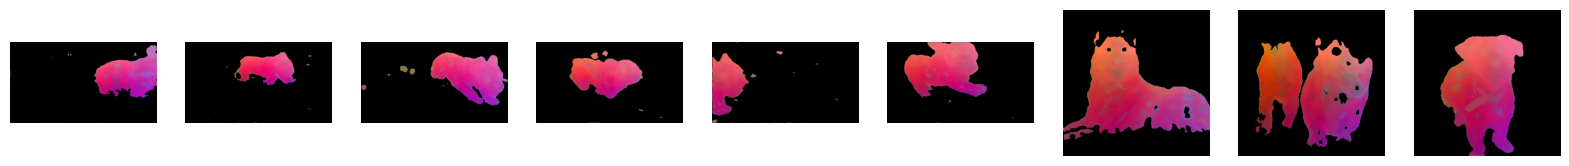

In [47]:
fig, axs = plt.subplots(nrows=1, ncols=9)
fig.set_size_inches(20, 8)
fg_feats = []
fg_masks = []

for i, feats in enumerate(subsample_features):
    test = subsample_shared_pca.transform(feats)
    test = rescale_pca(test)

    m1 = np.where(test[:, 0] > 0.5, 1, 0)
    m2 = np.where(test[:, 1] < 0.5, 1, 0)
    fg_mask = m1 * m2
    #fg_mask = np.reshape(fg_mask, (H * W, 1))
    fg_idxs = np.nonzero(fg_mask)
    fg_feat = feats[fg_idxs]
    fg_feats.append(fg_feat)
    fg_masks.append(fg_mask)

    if i < 6:
        new_shape = (H, W, 3)
    else:
        new_shape = (IH, IW, 3)

    ax = axs[i]
    ax.set_axis_off()
    ax.imshow(test.reshape(*new_shape) * fg_mask.reshape(*new_shape[:2], 1))

In [49]:
print(fg_feats[0].shape)
fg_projs, fg_pca = do_shared_pca(fg_feats)

(27171, 384)


(27171, 3)


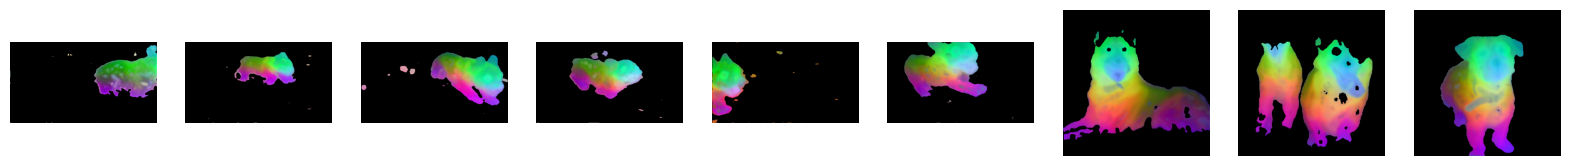

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=9)
print(fg_projs[0].shape)
fig.set_size_inches(20, 10)
for i, feats in enumerate(fg_projs):
    feats = rescale_pca(feats)
    mask = fg_masks[i]

    if i < 6:
        w, h  = W, H
    else:
        w, h = IW, IH


    out = np.zeros((h * w, 3))
    mask = mask.reshape(h * w, 1)
    mask = np.repeat(mask, 3, axis=-1)
    np.place(out, mask, feats)
    ax = axs[i]
    ax.set_axis_off()
    ax.imshow(out.reshape(h, w, 3))

In [51]:
frame_pcas = np.zeros((len(transformed_frames), H, W, 3), dtype=np.float16)

for i, frame in enumerate(transformed_frames):
    if i % 10 == 0:
        print(i)
    frame = frame.cuda()
    hy_feats, _ = net(frame)
    feat_hr_arr = tr.to_numpy(hy_feats)
    feat_hr_flat = tr.flatten(feat_hr_arr, H, W, net.feat_dim)
    frame = frame.cpu()

    test = subsample_shared_pca.transform(feat_hr_flat)
    test = rescale_pca(test)

    m1 = np.where(test[:, 0] > 0.5, 1, 0)
    m2 = np.where(test[:, 1] < 0.5, 1, 0)

    fg_mask = m1 * m2

    fg_idxs = np.nonzero(fg_mask)
    fg_feat = feat_hr_flat[fg_idxs]

    fg_proj = fg_pca.transform(fg_feat)
    fg_proj = rescale_pca(fg_proj)

    out = np.zeros((H * W, 3))
    mask = fg_mask.reshape(H * W, 1)
    mask = np.repeat(fg_mask, 3, axis=-1)
    np.place(out, mask, fg_proj)
    out = out.reshape(H, W, 3)
    frame_pcas[i] = out

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410


In [52]:
from PIL import Image
for i, img_arr in enumerate(frame_pcas):
    converted = (img_arr * 255).astype(np.uint8)
    img = Image.fromarray(converted, 'RGB')
    img.save(f"frame_data/{i:03d}.png")

```
ffmpeg -framerate 25 -pattern_type glob -i '*.png' -c:v libx264 -pix_fmt yuv420p out.mp4
```

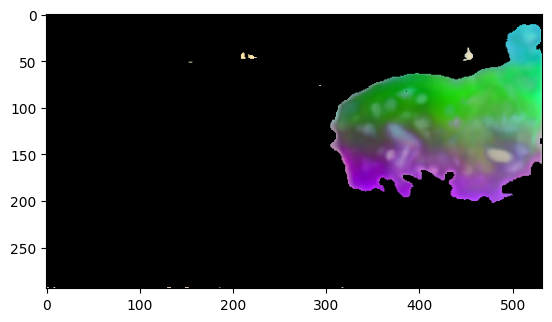

In [53]:
f1 = frame_pcas[0].astype(np.float64)
img = plt.imshow(f1)

In [22]:
img